In [1]:
#!pip --version
#!pip list -v
#!pip list
#!pip freeze
#!gcc -dumpversion
#!g++ -dumpversion
#!ld -v
#!gcc -shared --version

import pystan as stan
#import cmdstanpy
#from cmdstanpy import cmdstan_path
#import cmdstanpy
#cmdstanpy.install_cmdstan()
#cmdstan_path()

5.3.0
5.3.0
GNU ld (GNU Binutils) 2.25.1
gcc (Rev5, Built by MSYS2 project) 5.3.0
Copyright (C) 2015 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [7]:
import nest_asyncio
nest_asyncio.apply()

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import sys
import time
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
# get_ipython().run_line_magic('matplotlib', 'inline')

sns.color_palette("rocket")
sns.set_style('whitegrid')

In [8]:
df = pd.read_csv('data.csv')

to_drop_list= ['_sms']
to_drop=[]
for i in to_drop_list:
    aux = [col for col in df.columns if i in col]
    to_drop.extend(aux)
df.drop(to_drop,axis=1,inplace=True) 

# 1. media variables
# media impression
mdip_cols=[col for col in df.columns if 'mdip_' in col]
# media spending
mdsp_cols=[col for col in df.columns if 'mdsp_' in col]

# 2. control variables
# macro economics variables
me_cols = [col for col in df.columns if 'me_' in col]
# store count variables
st_cols = ['st_ct']
# markdown/discount variables
mrkdn_cols = [col for col in df.columns if 'mrkdn_' in col]
# holiday variables
hldy_cols = [col for col in df.columns if 'hldy_' in col]
# seasonality variables
seas_cols = [col for col in df.columns if 'seas_' in col]
base_vars = me_cols+st_cols+mrkdn_cols+hldy_cols+seas_cols

# 3. sales variables
sales_cols =['sales']

#df[['wk_strt_dt']+mdip_cols+['sales']].head()
#df.columns

In [9]:
# EDA - correlation, distribution plots
#plt.figure(figsize=(24,20))
#sns.heatmap(df[mdip_cols+['sales']].corr(), square=True, annot=True, vmax=1, vmin=-1, cmap='RdBu')
#
#plt.figure(figsize=(50,50))
#sns.pairplot(df[mdip_cols+['sales']], vars=mdip_cols+['sales'])

In [10]:
# 1.1 Adstock
def apply_adstock(x, L, P, D):
    '''
    params:
    x: original media variable, array
    L: length
    P: peak, delay in effect
    D: decay, retain rate
    returns:
    array, adstocked media variable
    '''
    x = np.append(np.zeros(L-1), x)
    
    weights = np.zeros(L)
    for l in range(L):
        weight = D**((l-P)**2)
        weights[L-1-l] = weight
    
    adstocked_x = []
    for i in range(L-1, len(x)):
        x_array = x[i-L+1:i+1]
        xi = sum(x_array * weights)/sum(weights)
        adstocked_x.append(xi)
    adstocked_x = np.array(adstocked_x)
    return adstocked_x

def adstock_transform(df, md_cols, adstock_params):
    '''
    params:
    df: original data
    md_cols: list, media variables to be transformed
    adstock_params: dict, 
        e.g., {'sem': {'L': 8, 'P': 0, 'D': 0.1}, 'dm': {'L': 4, 'P': 1, 'D': 0.7}}
    returns: 
    adstocked df
    '''
    md_df = pd.DataFrame()
    for md_col in md_cols:
        md = md_col.split('_')[-1]
        L, P, D = adstock_params[md]['L'], adstock_params[md]['P'], adstock_params[md]['D']
        xa = apply_adstock(df[md_col].values, L, P, D)
        md_df[md_col] = xa
    return md_df

# 1.2 Diminishing Return
def hill_transform(x, ec, slope):
    return 1 / (1 + (x / ec)**(-slope))

# 2. Model Implementation
# The model is built in a stacked way. Three models are trained:   
# - Control Model
# - Marketing Mix Model
# - Diminishing Return Model    

# 2.1 Control Model / Base Sales Model
import pystan
import os
#os.environ['PATH']  += ';C:\mingw64\\bin'  
os.environ['CC'] = 'gcc'
os.environ['CXX'] = 'g++'
#os.environ['CC'] = 'x86_64-apple-darwin13.4.0-clang'
#os.environ['CXX'] = 'x86_64-apple-darwin13.4.0-clang++'


# helper functions
from sklearn.metrics import mean_squared_error
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def apply_mean_center(x):
    mu = np.mean(x)
    xm = x/mu
    return xm, mu

def mean_center_trandform(df, cols):
    '''
    returns: 
    mean-centered df
    scaler, dict
    '''
    df_new = pd.DataFrame()
    sc = {}
    for col in cols:
        x = df[col].values
        df_new[col], mu = apply_mean_center(x)
        sc[col] = mu
    return df_new, sc

def mean_log1p_trandform(df, cols):
    '''
    returns: 
    mean-centered, log1p transformed df
    scaler, dict
    '''
    df_new = pd.DataFrame()
    sc = {}
    for col in cols:
        x = df[col].values
        xm, mu = apply_mean_center(x)
        sc[col] = mu
        df_new[col] = np.log1p(xm)
    return df_new, sc

import json

def save_json(data, file_name):
    with open(file_name, 'w') as fp:
        json.dump(data, fp)

def load_json(file_name):
    with open(file_name, 'r') as fp:
        data = json.load(fp)
    return data

In [12]:
# mean-centralize: sales, numeric base_vars
df_ctrl, sc_ctrl = mean_center_trandform(df, ['sales']+me_cols+st_cols+mrkdn_cols)
df_ctrl = pd.concat([df_ctrl, df[hldy_cols+seas_cols]], axis=1)

# variables positively related to sales: macro economy, store count, markdown, holiday
pos_vars = [col for col in base_vars if col not in seas_cols]
X1 = df_ctrl[pos_vars].values

# variables may have either positive or negtive impact on sales: seasonality
pn_vars = seas_cols
X2 = df_ctrl[pn_vars].values

ctrl_data = {
    'N': len(df_ctrl),
    'K1': len(pos_vars), 
    'K2': len(pn_vars), 
    'X1': X1,
    'X2': X2, 
    'y': df_ctrl['sales'].values,
    'max_intercept': min(df_ctrl['sales'])
}

ctrl_code1 = '''
data {
  int N; // number of observations
  int K1; // number of positive predictors
  int K2; // number of positive/negative predictors
  real max_intercept; // restrict the intercept to be less than the minimum y
  matrix[N, K1] X1;
  matrix[N, K2] X2;
  vector[N] y; 
}

parameters {
  vector[K1] beta1; // regression coefficients for X1 (positive)
  vector[K2] beta2; // regression coefficients for X2
  real alpha; // intercept
  real noise_var; // residual variance
}

model {
  // Define the priors
  beta1 ~ normal(0, 1); 
  beta2 ~ normal(0, 1); 
  noise_var ~ inv_gamma(0.05, 0.05 * 0.01);
  // The likelihood
  y ~ normal(X1*beta1 + X2*beta2 + alpha, sqrt(noise_var));
}
'''

sm1 = stan.StanModel(model_code=ctrl_code1, verbose=True)
fit1 = sm1.sampling(data=ctrl_data, iter=2000, chains=4)
fit1_result = fit1.extract()

In [16]:
# extract control model parameters and predict base sales -> df['base_sales']
def extract_ctrl_model(fit_result, pos_vars=pos_vars, pn_vars=pn_vars, 
                       extract_param_list=False):
    ctrl_model = {}
    ctrl_model['pos_vars'] = pos_vars
    ctrl_model['pn_vars'] = pn_vars
    ctrl_model['beta1'] = fit_result['beta1'].mean(axis=0).tolist()
    ctrl_model['beta2'] = fit_result['beta2'].mean(axis=0).tolist()
    ctrl_model['alpha'] = fit_result['alpha'].mean()
    if extract_param_list:
        ctrl_model['beta1_list'] = fit_result['beta1'].tolist()
        ctrl_model['beta2_list'] = fit_result['beta2'].tolist()
        ctrl_model['alpha_list'] = fit_result['alpha'].tolist()
    return ctrl_model

def ctrl_model_predict(ctrl_model, df):
    pos_vars, pn_vars = ctrl_model['pos_vars'], ctrl_model['pn_vars'] 
    X1, X2 = df[pos_vars], df[pn_vars]
    beta1, beta2 = np.array(ctrl_model['beta1']), np.array(ctrl_model['beta2'])
    alpha = ctrl_model['alpha']
    y_pred = np.dot(X1, beta1) + np.dot(X2, beta2) + alpha
    return y_pred

base_sales_model = extract_ctrl_model(fit1_result, pos_vars=pos_vars, pn_vars=pn_vars)
base_sales = ctrl_model_predict(base_sales_model, df_ctrl)
df['base_sales'] = base_sales*sc_ctrl['sales']
# evaluate control model
print('mape: ', mean_absolute_percentage_error(df['sales'], df['base_sales']))

# np.savetxt("base_sales_pred.csv", df['base_sales'].values, delimiter=",")
# save_json(base_sales_model, 'ctrl_model.json')
# df['base_sales'] = pd.read_csv('base_sales_pred.csv', header=None).values



mape:  24.3915321450511


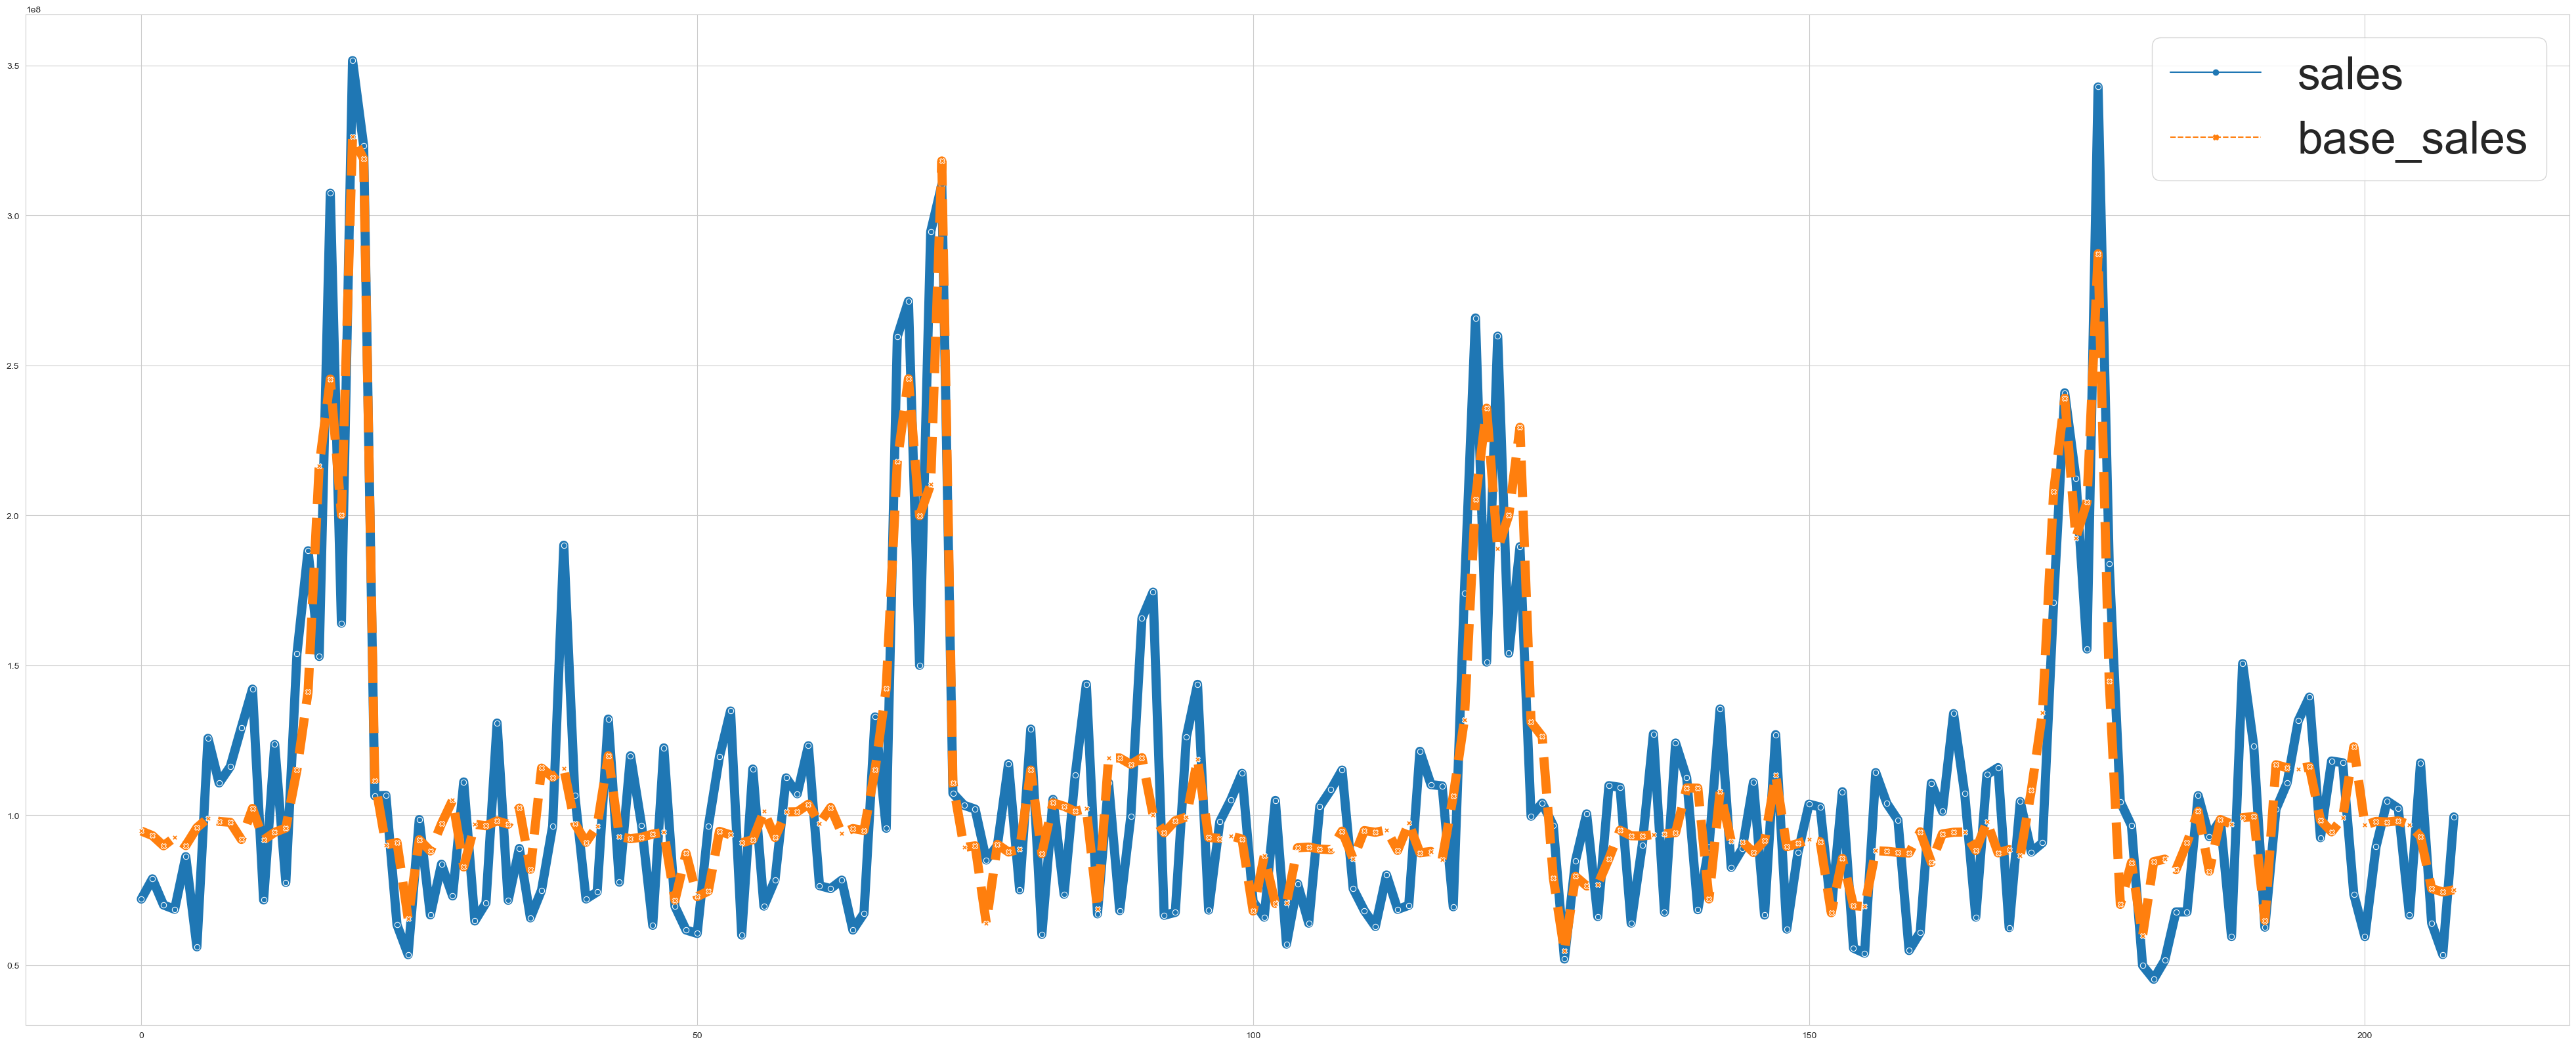

In [17]:
df1_plot = df[['wk_strt_dt','sales','base_sales']]
plt.figure(figsize=(50,20))
sns.lineplot(data=df1_plot,markers=True, dashes=True, linewidth=10)
plt.legend(fontsize='50')

In [21]:
# 2.2 Marketing Mix Model
df_mmm, sc_mmm = mean_log1p_trandform(df, ['sales', 'base_sales'])
mu_mdip = df[mdip_cols].apply(np.mean, axis=0).values
max_lag = 8
num_media = len(mdip_cols)
# padding zero * (max_lag-1) rows
X_media = np.concatenate((np.zeros((max_lag-1, num_media)), df[mdip_cols].values), axis=0)
X_ctrl = df_mmm['base_sales'].values.reshape(len(df),1)
model_data2 = {
    'N': len(df),
    'max_lag': max_lag, 
    'num_media': num_media,
    'X_media': X_media, 
    'mu_mdip': mu_mdip,
    'num_ctrl': X_ctrl.shape[1],
    'X_ctrl': X_ctrl, 
    'y': df_mmm['sales'].values
}

model_code2 = '''
functions {
  // the adstock transformation with a vector of weights
  real Adstock(vector t, row_vector weights) {
    return dot_product(t, weights) / sum(weights);
  }
}
data {
  // the total number of observations
  int N;
  // the vector of sales
  real y[N];
  // the maximum duration of lag effect, in weeks
  int max_lag;
  // the number of media channels
  int num_media;
  // matrix of media variables
  matrix[N+max_lag-1, num_media] X_media;
  // vector of media variables' mean
  real mu_mdip[num_media];
  // the number of other control variables
  int num_ctrl;
  // a matrix of control variables
  matrix[N, num_ctrl] X_ctrl;
}
parameters {
  // residual variance
  real<lower=0> noise_var;
  // the intercept
  real tau;
  // the coefficients for media variables and base sales
  vector<lower=0>[num_media+num_ctrl] beta;
  // the decay and peak parameter for the adstock transformation of
  // each media
  vector<lower=0,upper=1>[num_media] decay;
  vector<lower=0,upper=ceil(max_lag/2)>[num_media] peak;
}
transformed parameters {
  // the cumulative media effect after adstock
  real cum_effect;
  // matrix of media variables after adstock
  matrix[N, num_media] X_media_adstocked;
  // matrix of all predictors
  matrix[N, num_media+num_ctrl] X;
  
  // adstock, mean-center, log1p transformation
  row_vector[max_lag] lag_weights;
  for (nn in 1:N) {
    for (media in 1 : num_media) {
      for (lag in 1 : max_lag) {
        lag_weights[max_lag-lag+1] <- pow(decay[media], (lag - 1 - peak[media]) ^ 2);
      }
     cum_effect <- Adstock(sub_col(X_media, nn, media, max_lag), lag_weights);
     X_media_adstocked[nn, media] <- log1p(cum_effect/mu_mdip[media]);
    }
  X <- append_col(X_media_adstocked, X_ctrl);
  } 
}
model {
  decay ~ beta(3,3);
  peak ~ uniform(0, ceil(max_lag/2));
  tau ~ normal(0, 5);
  for (i in 1 : num_media+num_ctrl) {
    beta[i] ~ normal(0, 1);
  }
  noise_var ~ inv_gamma(0.05, 0.05 * 0.01);
  y ~ normal(tau + X * beta, sqrt(noise_var));
}
'''

sm2 = pystan.StanModel(model_code=model_code2, verbose=True)
fit2 = sm2.sampling(data=model_data2, iter=1000, chains=3)
fit2_result = fit2.extract()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b66d5c7f23b8c13b3f707d437baf6ad9 NOW.
INFO:pystan:OS: win32, Python: 3.7.15 (default, Nov 24 2022, 18:44:54) [MSC v.1916 64 bit (AMD64)], Cython 0.29.32


Compiling C:\Users\ROLAND~1.ANZ\AppData\Local\Temp\pystan_mkc0u17r\stanfit4anon_model_b66d5c7f23b8c13b3f707d437baf6ad9_3174112157519795744.pyx because it changed.
[1/1] Cythonizing C:\Users\ROLAND~1.ANZ\AppData\Local\Temp\pystan_mkc0u17r\stanfit4anon_model_b66d5c7f23b8c13b3f707d437baf6ad9_3174112157519795744.pyx
building 'stanfit4anon_model_b66d5c7f23b8c13b3f707d437baf6ad9_3174112157519795744' extension
C:\Users\Rolando.Anzola\Anaconda3\envs\mmm\Library\mingw-w64\bin\gcc.exe -mdll -O -Wall -DMS_WIN64 -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -IC:\Users\ROLAND~1.ANZ\AppData\Local\Temp\pystan_mkc0u17r -IC:\Users\Rolando.Anzola\Anaconda3\envs\mmm\lib\site-packages\pystan -IC:\Users\Rolando.Anzola\Anaconda3\envs\mmm\lib\site-packages\pystan\stan\src -IC:\Users\Rolando.Anzola\Anaconda3\envs\mmm\lib\site-packages\pystan\stan\lib\stan_math -IC:\Users\Rolando.Anzola\Anaconda3\envs\mmm\lib\site-packages\pystan\stan\lib\stan_math\lib\eigen_3.3.3 -IC:\Users\Rolando.Anz

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


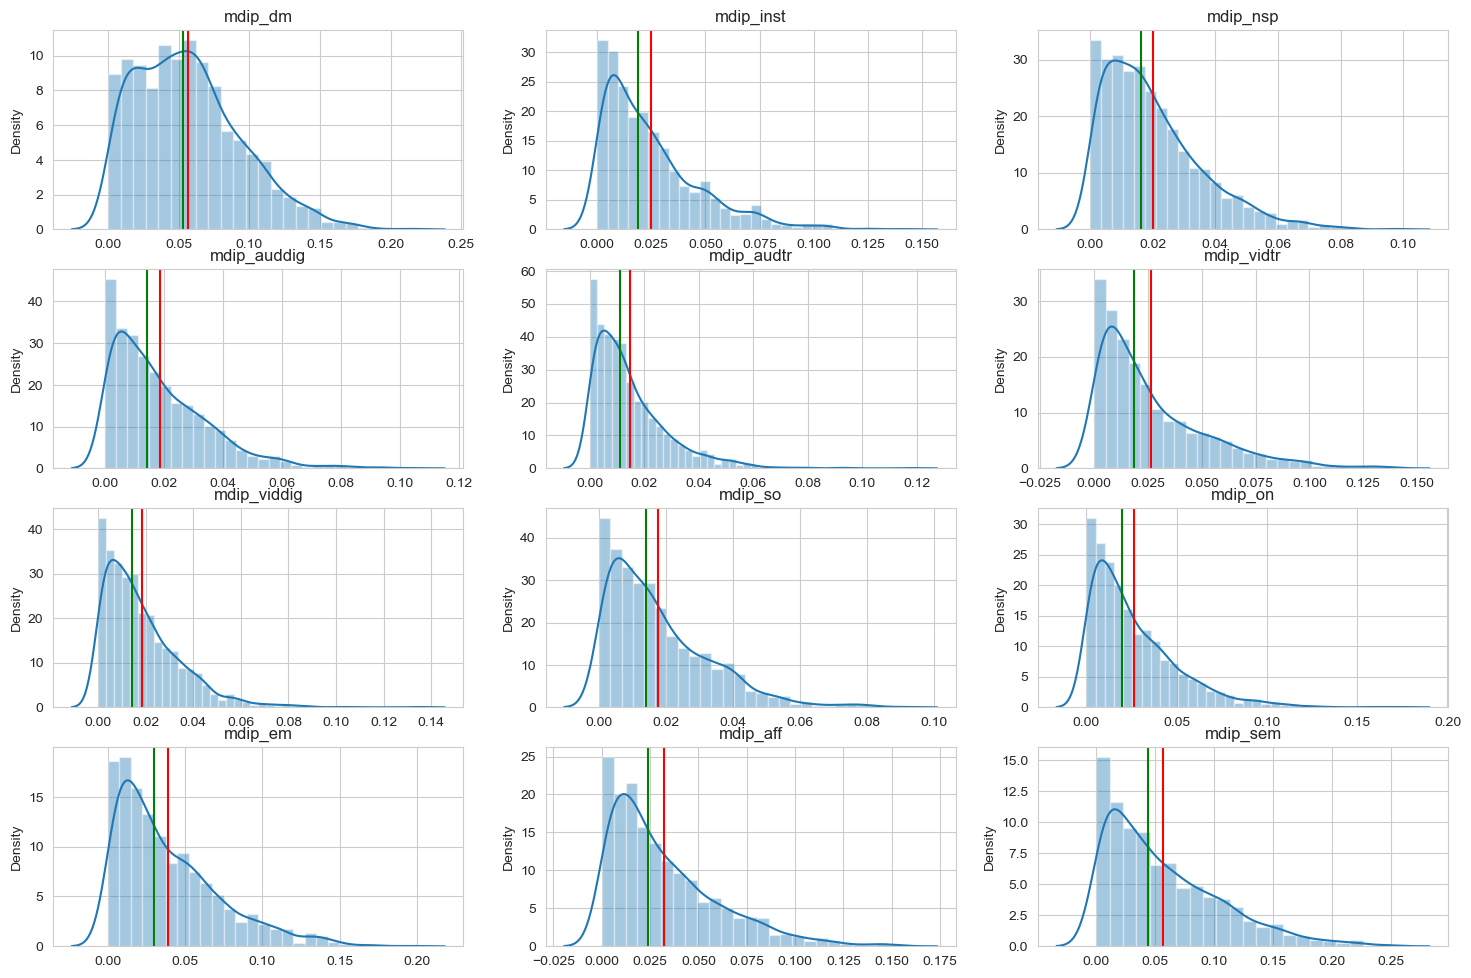

In [22]:
# extract mmm parameters
def extract_mmm(fit_result, max_lag=max_lag, 
                media_vars=mdip_cols, ctrl_vars=['base_sales'], 
                extract_param_list=True):
    mmm = {}
    
    mmm['max_lag'] = max_lag
    mmm['media_vars'], mmm['ctrl_vars'] = media_vars, ctrl_vars
    mmm['decay'] = decay = fit_result['decay'].mean(axis=0).tolist()
    mmm['peak'] = peak = fit_result['peak'].mean(axis=0).tolist()
    mmm['beta'] = fit_result['beta'].mean(axis=0).tolist()
    mmm['tau'] = fit_result['tau'].mean()
    if extract_param_list:
        mmm['decay_list'] = fit_result['decay'].tolist()
        mmm['peak_list'] = fit_result['peak'].tolist()
        mmm['beta_list'] = fit_result['beta'].tolist()
        mmm['tau_list'] = fit_result['tau'].tolist()
    
    adstock_params = {}
    media_names = [col.replace('mdip_', '') for col in media_vars]
    for i in range(len(media_names)):
        adstock_params[media_names[i]] = {
            'L': max_lag,
            'P': peak[i],
            'D': decay[i]
        }
    mmm['adstock_params'] = adstock_params
    return mmm

mmm = extract_mmm(fit2, max_lag=max_lag, 
                media_vars=mdip_cols, ctrl_vars=['base_sales'])
# save_json(mmm, 'mmm1.json')


# plot media coefficients' distributions
# red line: mean, green line: median
beta_media = {}
for i in range(len(mmm['media_vars'])):
    md = mmm['media_vars'][i]
    betas = []
    for j in range(len(mmm['beta_list'])):
        betas.append(mmm['beta_list'][j][i])
    beta_media[md] = np.array(betas)

f = plt.figure(figsize=(18,15))
for i in range(len(mmm['media_vars'])):
    ax = f.add_subplot(5,3,i+1)
    md = mmm['media_vars'][i]
    x = beta_media[md]
    mean_x = x.mean()
    median_x = np.median(x)
    ax = sns.distplot(x)
    ax.axvline(mean_x, color='r', linestyle='-')
    ax.axvline(median_x, color='g', linestyle='-')
    ax.set_title(md)

In [23]:
# Decompose sales to media channels' contribution
# Each media channel's contribution = total sales - sales upon removal the channel    

# decompose sales to media contribution
def mmm_decompose_contrib(mmm, df, original_sales=df['sales']):
    # adstock params
    adstock_params = mmm['adstock_params']
    # coefficients, intercept
    beta, tau = mmm['beta'], mmm['tau']
    # variables
    media_vars, ctrl_vars = mmm['media_vars'], mmm['ctrl_vars']
    num_media, num_ctrl = len(media_vars), len(ctrl_vars)
    # X_media2: adstocked, mean-centered media variables + 1
    X_media2 = adstock_transform(df, media_vars, adstock_params)
    X_media2, sc_mmm2 = mean_center_trandform(X_media2, media_vars)
    X_media2 = X_media2 + 1
    # X_ctrl2, mean-centered control variables + 1
    X_ctrl2, sc_mmm2_1 = mean_center_trandform(df[ctrl_vars], ctrl_vars)
    X_ctrl2 = X_ctrl2 + 1
    # y_true2, mean-centered sales variable + 1
    y_true2, sc_mmm2_2 = mean_center_trandform(df, ['sales'])
    y_true2 = y_true2 + 1
    sc_mmm2.update(sc_mmm2_1)
    sc_mmm2.update(sc_mmm2_2)
    # X2 <- media variables + ctrl variable
    X2 = pd.concat([X_media2, X_ctrl2], axis=1)

    # 1. compute each media/control factor: 
    # log-log model: log(sales) = log(X[0])*beta[0] + ... + log(X[13])*beta[13] + tau
    # multiplicative model: sales = X[0]^beta[0] * ... * X[13]^beta[13] * e^tau
    # each factor = X[i]^beta[i]
    # intercept = e^tau
    factor_df = pd.DataFrame(columns=media_vars+ctrl_vars+['intercept'])
    for i in range(num_media):
        colname = media_vars[i]
        factor_df[colname] = X2[colname] ** beta[i]
    for i in range(num_ctrl):
        colname = ctrl_vars[i]
        factor_df[colname] = X2[colname] ** beta[num_media+i]
    factor_df['intercept'] = np.exp(tau)

    # 2. calculate the product of all factors -> y_pred
    # baseline = intercept * control factor = e^tau * X[13]^beta[13]
    y_pred = factor_df.apply(np.prod, axis=1)
    factor_df['y_pred'], factor_df['y_true2'] = y_pred, y_true2
    factor_df['baseline'] = factor_df[['intercept']+ctrl_vars].apply(np.prod, axis=1)

    # 3. calculate each media factor's contribution
    # media contribution = total volume – volume upon removal of the media factor
    mc_df = pd.DataFrame(columns=media_vars+['baseline'])
    for col in media_vars:
        mc_df[col] = factor_df['y_true2'] - factor_df['y_true2']/factor_df[col]
    mc_df['baseline'] = factor_df['baseline']
    mc_df['y_true2'] = factor_df['y_true2']

    # 4. scale contribution
    # predicted total media contribution: product of all media factors
    mc_df['mc_pred'] = mc_df[media_vars].apply(np.sum, axis=1)
    # true total media contribution: total volume - baseline
    mc_df['mc_true'] = mc_df['y_true2'] - mc_df['baseline']
    # predicted total media contribution is slightly different from true total media contribution
    # scale each media factor’s contribution by removing the delta volume proportionally
    mc_df['mc_delta'] =  mc_df['mc_pred'] - mc_df['mc_true']
    for col in media_vars:
        mc_df[col] = mc_df[col] - mc_df['mc_delta']*mc_df[col]/mc_df['mc_pred']

    # 5. scale mc_df based on original sales
    mc_df['sales'] = original_sales
    for col in media_vars+['baseline']:
        mc_df[col] = mc_df[col]*mc_df['sales']/mc_df['y_true2']
    
    print('rmse (log-log model): ', 
         mean_squared_error(np.log(y_true2), np.log(y_pred)) ** (1/2))
    print('mape (multiplicative model): ', 
         mean_absolute_percentage_error(y_true2, y_pred))
    return mc_df

# calculate media contribution percentage
def calc_media_contrib_pct(mc_df, media_vars=mdip_cols, sales_col='sales', period=52):
    '''
    returns:
    mc_pct: percentage over total sales
    mc_pct2: percentage over incremental sales (sales contributed by media channels)
    '''
    mc_pct = {}
    mc_pct2 = {}
    s = 0
    if period is None:
        for col in (media_vars+['baseline']):
            mc_pct[col] = (mc_df[col]/mc_df[sales_col]).mean()
    else:
        for col in (media_vars+['baseline']):
            mc_pct[col] = (mc_df[col]/mc_df[sales_col])[-period:].mean()
    for m in media_vars:
        s += mc_pct[m]
    for m in media_vars:
        mc_pct2[m] = mc_pct[m]/s
    return mc_pct, mc_pct2

mc_df = mmm_decompose_contrib(mmm, df, original_sales=df['sales'])
adstock_params = mmm['adstock_params']
mc_pct, mc_pct2 = calc_media_contrib_pct(mc_df, period=52)
# mc_df.to_csv('mc_df1.csv', index=False)
# save_json(adstock_params, 'adstock_params1.json')
# pd.concat([
#     pd.DataFrame.from_dict(mc_pct, orient='index', columns=['mc_pct']),
#     pd.DataFrame.from_dict(mc_pct2, orient='index', columns=['mc_pct2'])
# ], axis=1).to_csv('mc_pct_df1.csv')


rmse (log-log model):  0.12779703269620726
mape (multiplicative model):  20.54548182999814


In [24]:
mc_pct2

{'mdip_dm': 0.11857716604036037,
 'mdip_inst': 0.05430389439088164,
 'mdip_nsp': 0.009009376839889454,
 'mdip_auddig': 0.07828656359747069,
 'mdip_audtr': 0.04734524489565579,
 'mdip_vidtr': 0.07596687512651373,
 'mdip_viddig': 0.050967159523014643,
 'mdip_so': 0.06953240986678452,
 'mdip_on': 0.07867520149668696,
 'mdip_em': 0.13358011552475638,
 'mdip_aff': 0.1000133232587372,
 'mdip_sem': 0.18374266943924852}

In [25]:
# 2.3 Diminishing Return Model    
def create_hill_model_data(df, mc_df, adstock_params, media):
    y = mc_df['mdip_'+media].values
    L, P, D = adstock_params[media]['L'], adstock_params[media]['P'], adstock_params[media]['D']
    x = df['mdsp_'+media].values
    x_adstocked = apply_adstock(x, L, P, D)
    # centralize
    mu_x, mu_y = x_adstocked.mean(), y.mean()
    sc = {'x': mu_x, 'y': mu_y}
    x = x_adstocked/mu_x
    y = y/mu_y
        
    model_data = {
        'N': len(y),
        'y': y,
        'X': x
    }
    return model_data, sc

model_code3 = '''
functions {
  // the Hill function
  real Hill(real t, real ec, real slope) {
  return 1 / (1 + (t / ec)^(-slope));
  }
}

data {
  // the total number of observations
  int N;
  // y: vector of media contribution
  vector[N] y;
  // X: vector of adstocked media spending
  vector[N] X;
}

parameters {
  // residual variance
  real noise_var;
  // regression coefficient
  real beta_hill;
  // ec50 and slope for Hill function of the media
  real ec;
  real slope;
}

transformed parameters {
  // a vector of the mean response
  vector[N] mu;
  for (i in 1:N) {
    mu[i] <- beta_hill * Hill(X[i], ec, slope);
  }
}

model {
  slope ~ gamma(3, 1);
  ec ~ beta(2, 2);
  beta_hill ~ normal(0, 1);
  noise_var ~ inv_gamma(0.05, 0.05 * 0.01); 
  y ~ normal(mu, sqrt(noise_var));
}
'''

# pipeline for training one hill model for a media channel
def train_hill_model(df, mc_df, adstock_params, media, sm):
    '''
    params:
    df: original data
    mc_df: media contribution df derived from MMM
    adstock_params: adstock parameter dict output by MMM
    media: 'dm', 'inst', 'nsp', 'auddig', 'audtr', 'vidtr', 'viddig', 'so', 'on', 'sem'
    sm: stan model object    
    returns:
    a dict of model data, scaler, parameters
    '''
    data, sc = create_hill_model_data(df, mc_df, adstock_params, media)
    fit = sm.sampling(data=data, iter=2000, chains=4)
    fit_result = fit.extract()
    hill_model = {
        'beta_hill_list': fit_result['beta_hill'].tolist(),
        'ec_list': fit_result['ec'].tolist(),
        'slope_list': fit_result['slope'].tolist(),
        'sc': sc,
        'data': {
            'X': data['X'].tolist(),
            'y': data['y'].tolist(),
        }
    }
    return hill_model

# extract params by mean or median
# almost no difference, choose either one
def extract_hill_model_params(hill_model, method='mean'):
    if method=='mean':
        hill_model_params = {
            'beta_hill': np.mean(hill_model['beta_hill_list']), 
            'ec': np.mean(hill_model['ec_list']), 
            'slope': np.mean(hill_model['slope_list'])
        }
    elif method=='median':
        hill_model_params = {
            'beta_hill': np.median(hill_model['beta_hill_list']), 
            'ec': np.median(hill_model['ec_list']), 
            'slope': np.median(hill_model['slope_list'])
        }
    return hill_model_params

def hill_model_predict(hill_model_params, x):
    beta_hill, ec, slope = hill_model_params['beta_hill'], hill_model_params['ec'], hill_model_params['slope']
    y_pred = beta_hill * hill_transform(x, ec, slope)
    return y_pred

def evaluate_hill_model(hill_model, hill_model_params):
    x = np.asarray(hill_model['data']['X'])
    y_true = np.asarray(hill_model['data']['y']) * hill_model['sc']['y']
    y_pred = hill_model_predict(hill_model_params, x) * hill_model['sc']['y']
    print('mape on original data: ', 
         mean_absolute_percentage_error(y_true, y_pred))
    return y_true, y_pred



In [26]:
# train hill models for all media channels
sm3 = pystan.StanModel(model_code=model_code3, verbose=True)
hill_models = {}
to_train = ['dm', 'inst', 'nsp', 'auddig', 'audtr', 'vidtr', 'viddig', 'so', 'on', 'sem']
for media in to_train:
    print('training for media: ', media)
    hill_model = train_hill_model(df, mc_df, adstock_params, media, sm3)
    print("trained for media: ", media)
    hill_models[media] = hill_model

# extract params by mean
hill_model_params_mean, hill_model_params_med = {}, {}
for md in list(hill_models.keys()):
    print("extracting " + md)
    hill_model = hill_models[md]
    params1 = extract_hill_model_params(hill_model, method='mean')
    params1['sc'] = hill_model['sc']
    hill_model_params_mean[md] = params1
#     params2 = extract_hill_model_params(hill_model, method='median')
#     params2['sc'] = hill_model['sc']
#     hill_model_params_med[md] = params2
# save_json(hill_model_params_med, 'hill_model_params_med.json')
# save_json(hill_model_params_mean, 'hill_model_params_mean.json')

# evaluate model params extracted by mean
for md in list(hill_models.keys()):
    print('evaluating media: ', md)
    hill_model = hill_models[md]
    hill_model_params = hill_model_params_mean[md]
    _ = evaluate_hill_model(hill_model, hill_model_params)
# evaluate model params extracted by median
# for md in list(hill_models.keys()):
#     print('evaluating media: ', md)
#     hill_model = hill_models[md]
#     hill_model_params = hill_model_params_med[md]
#     _ = evaluate_hill_model(hill_model, hill_model_params)



INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_eaab4b98f35ad9c28152e61bd7b140e7 NOW.
INFO:pystan:OS: win32, Python: 3.7.15 (default, Nov 24 2022, 18:44:54) [MSC v.1916 64 bit (AMD64)], Cython 0.29.32


Compiling C:\Users\ROLAND~1.ANZ\AppData\Local\Temp\pystan_ioz8ufzm\stanfit4anon_model_eaab4b98f35ad9c28152e61bd7b140e7_288866108430242820.pyx because it changed.
[1/1] Cythonizing C:\Users\ROLAND~1.ANZ\AppData\Local\Temp\pystan_ioz8ufzm\stanfit4anon_model_eaab4b98f35ad9c28152e61bd7b140e7_288866108430242820.pyx
building 'stanfit4anon_model_eaab4b98f35ad9c28152e61bd7b140e7_288866108430242820' extension
C:\Users\Rolando.Anzola\Anaconda3\envs\mmm\Library\mingw-w64\bin\gcc.exe -mdll -O -Wall -DMS_WIN64 -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -IC:\Users\ROLAND~1.ANZ\AppData\Local\Temp\pystan_ioz8ufzm -IC:\Users\Rolando.Anzola\Anaconda3\envs\mmm\lib\site-packages\pystan -IC:\Users\Rolando.Anzola\Anaconda3\envs\mmm\lib\site-packages\pystan\stan\src -IC:\Users\Rolando.Anzola\Anaconda3\envs\mmm\lib\site-packages\pystan\stan\lib\stan_math -IC:\Users\Rolando.Anzola\Anaconda3\envs\mmm\lib\site-packages\pystan\stan\lib\stan_math\lib\eigen_3.3.3 -IC:\Users\Rolando.Anzola

trained for media:  dm
training for media:  inst


trained for media:  inst
training for media:  nsp


trained for media:  nsp
training for media:  auddig


trained for media:  auddig
training for media:  audtr


trained for media:  audtr
training for media:  vidtr


trained for media:  vidtr
training for media:  viddig


trained for media:  viddig
training for media:  so


trained for media:  so
training for media:  on


trained for media:  on
training for media:  sem


trained for media:  sem
extracting dm
extracting inst
extracting nsp
extracting auddig
extracting audtr
extracting vidtr
extracting viddig
extracting so
extracting on
extracting sem
evaluating media:  dm
mape on original data:  252.0782640581169
evaluating media:  inst
mape on original data:  396.82460407335594
evaluating media:  nsp
mape on original data:  411.11614212343727
evaluating media:  auddig
mape on original data:  455.83000913389674
evaluating media:  audtr
mape on original data:  364.03709629710966
evaluating media:  vidtr
mape on original data:  402.1468640341824
evaluating media:  viddig
mape on original data:  357.07094837956555
evaluating media:  so
mape on original data:  nan
evaluating media:  on
mape on original data:  392.2619363048435
evaluating media:  sem
mape on original data:  321.4861024558884


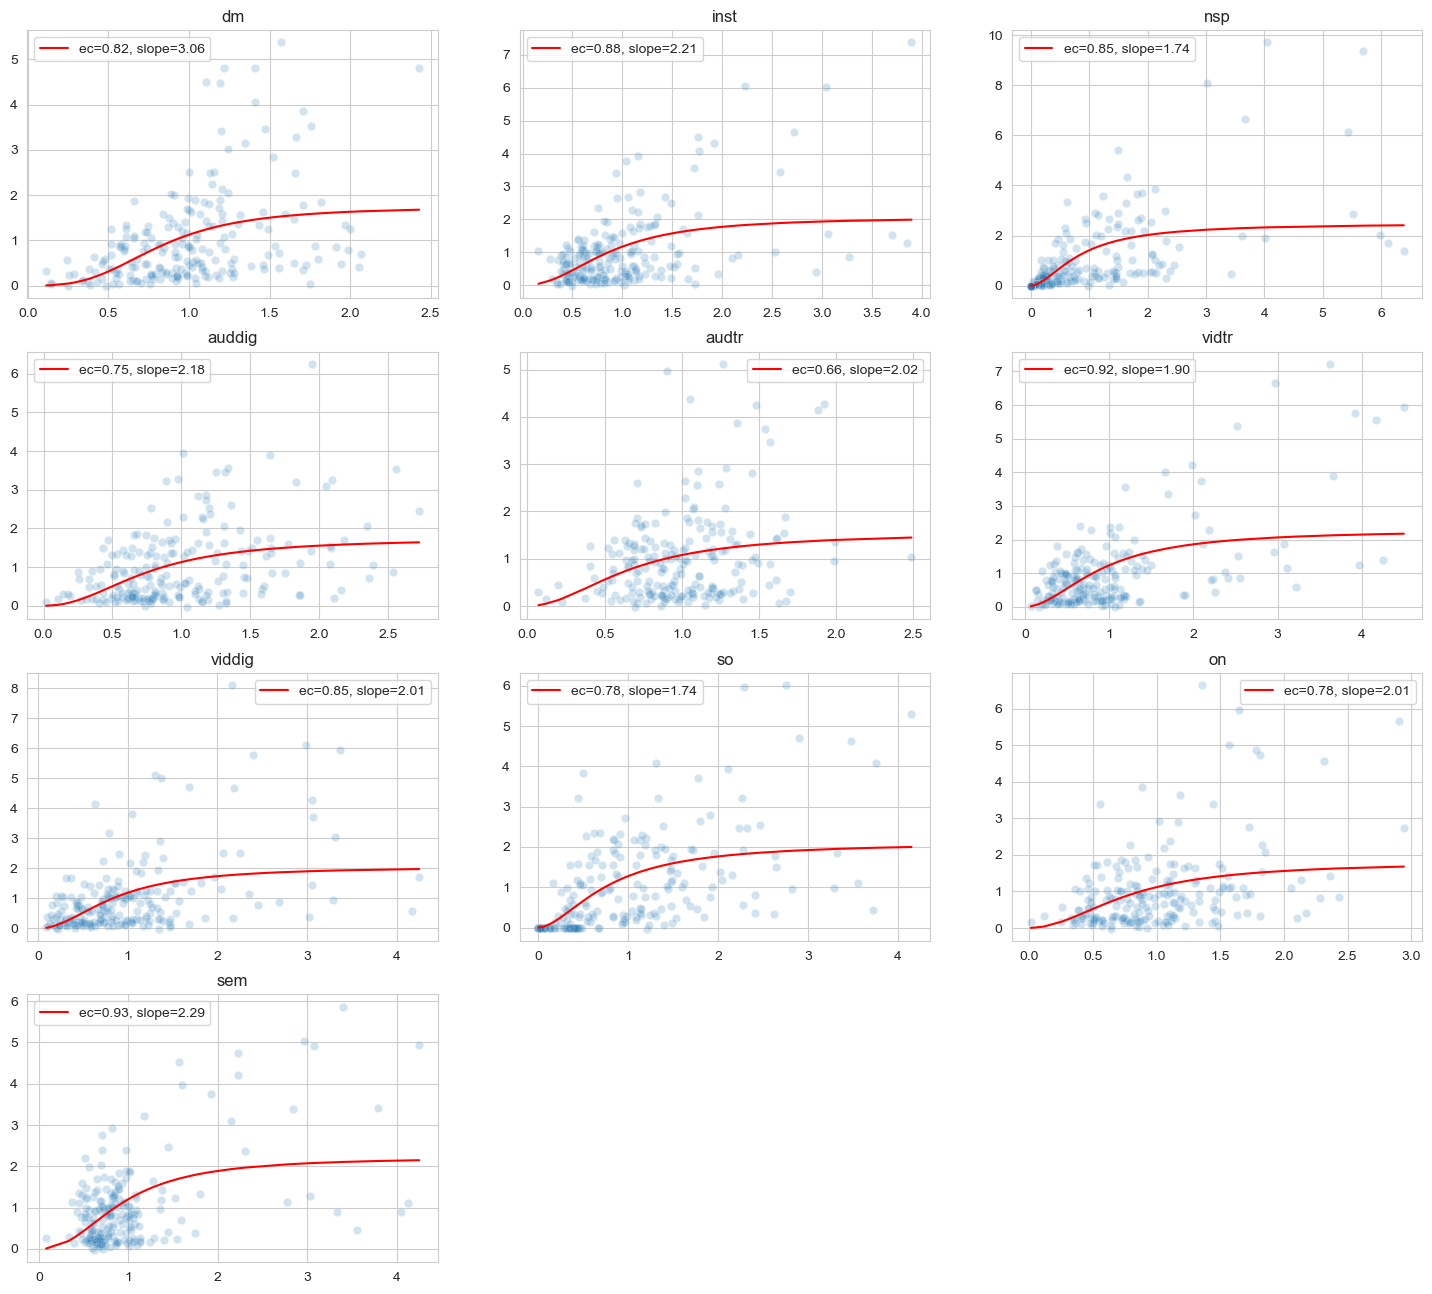

In [27]:
# plot fitted hill function
f = plt.figure(figsize=(18,16))
hm_keys = list(hill_models.keys())
for i in range(len(hm_keys)):
    ax = f.add_subplot(4,3,i+1)
    md = hm_keys[i]
    hm = hill_models[md]
    hmp = hill_model_params_mean[md]
    x, y = hm['data']['X'], hm['data']['y']
    #mu_x, mu_y = hm['sc']['x'], hm['sc']['y']
    ec, slope = hmp['ec'], hmp['slope']
    x_sorted = np.array(sorted(x))
    y_fit = hill_model_predict(hmp, x_sorted)
    ax = sns.scatterplot(x=x, y=y, alpha=0.2)
    ax = sns.lineplot(x=x_sorted, y=y_fit, color='r', 
                 label='ec=%.2f, slope=%.2f'%(ec, slope))
    ax.set_title(md)

,roas_mean,roas_median,mroas,roas_avg
dm,4.929503,4.755948,6.808227,5.179648
inst,25.828764,23.327676,30.006830,26.385058
nsp,5.290044,3.567865,7.422059,6.917450
auddig,353.543661,292.508839,146.591843,340.674685
audtr,9.436310,8.390606,5.324744,9.130344
vidtr,16.246677,12.069359,9.383995,14.026268
viddig,56.550017,57.376793,45.724221,62.179120
so,9.765045,8.687054,4.085173,9.579529
on,6.861861,6.011692,4.696580,6.884493
sem,6.560356,6.152917,6.311787,6.271963


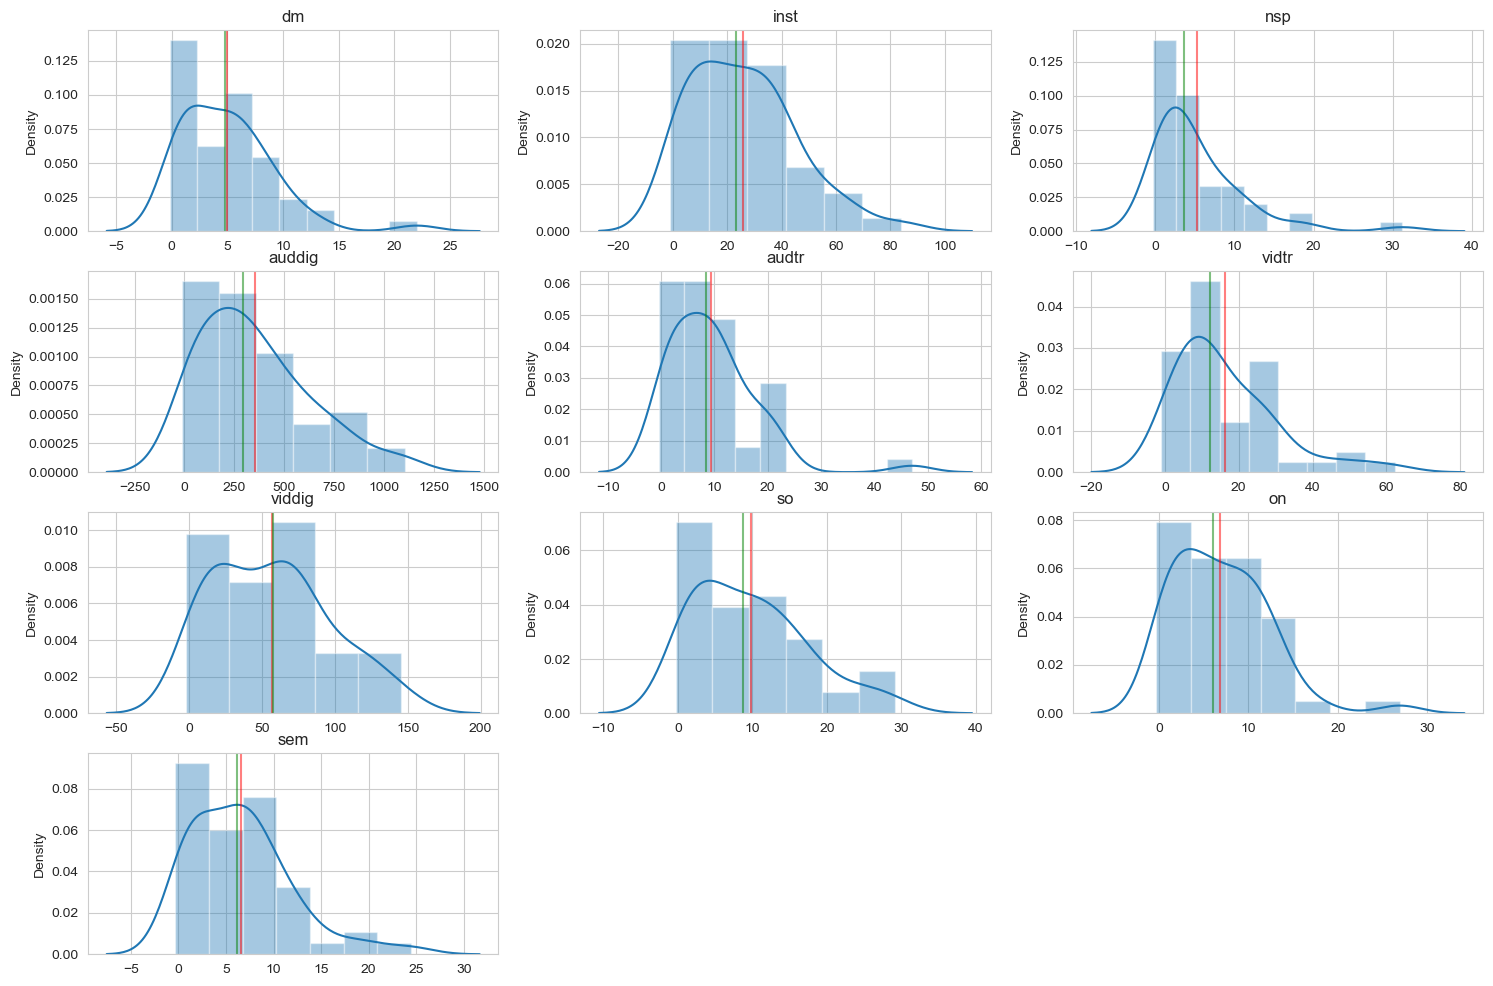

In [28]:
# Calculate overall ROAS and weekly ROAS
# - Overall ROAS = total contribution / total spending
# - Weekly ROAS = weekly contribution / weekly spending

# adstocked media spending
ms_df = pd.DataFrame()
for md in list(hill_models.keys()):
    hill_model = hill_models[md]
    x = np.array(hill_model['data']['X']) * hill_model['sc']['x']
    ms_df['mdsp_'+md] = x
# ms_df.to_csv('ms_df1.csv', index=False)

# calc overall ROAS of a given period
def calc_roas(mc_df, ms_df, period=None):
    roas = {}
    md_names = [col.split('_')[-1] for col in ms_df.columns]
    for i in range(len(md_names)):
        md = md_names[i]
        sp, mc = ms_df['mdsp_'+md], mc_df['mdip_'+md]
        if period is None:
            md_roas = mc.sum()/sp.sum()
        else:
            md_roas = mc[-period:].sum()/sp[-period:].sum()
        roas[md] = md_roas
    return roas

# calc weekly ROAS
def calc_weekly_roas(mc_df, ms_df):
    weekly_roas = pd.DataFrame()
    md_names = [col.split('_')[-1] for col in ms_df.columns]
    for md in md_names:
        weekly_roas[md] = mc_df['mdip_'+md]/ms_df['mdsp_'+md]
    weekly_roas.replace([np.inf, -np.inf, np.nan], 0, inplace=True)
    return weekly_roas

roas_1y = calc_roas(mc_df, ms_df, period=52)
weekly_roas = calc_weekly_roas(mc_df, ms_df)
roas1y_df = pd.DataFrame(index=weekly_roas.columns.tolist())
roas1y_df['roas_mean'] = weekly_roas[-52:].apply(np.mean, axis=0)
roas1y_df['roas_median'] = weekly_roas[-52:].apply(np.median, axis=0)


# # plot weekly ROAS distribution
# # median: green line, mean: red line
# f = plt.figure(figsize=(18,12))
# for i in range(len(weekly_roas.columns)):
#     md = weekly_roas.columns[i]
#     ax = f.add_subplot(4,3,i+1)
#     x = weekly_roas[md]
#     mean_x = np.mean(x)
#     median_x = np.median(x)
#     ax = sns.distplot(x)
#     ax.axvline(mean_x, color='r', linestyle='-', alpha=0.5)
#     ax.axvline(median_x, color='g', linestyle='-', alpha=0.5)
#     ax.set(xlabel=None)
#     ax.set_title(md)

# plot weekly ROAS distribution of past 1 year
# median: green line, mean: red line
f = plt.figure(figsize=(18,12))
for i in range(len(weekly_roas.columns)):
    md = weekly_roas.columns[i]
    ax = f.add_subplot(4,3,i+1)
    x = weekly_roas[md][-52:]
    mean_x = np.mean(x)
    median_x = np.median(x)
    ax = sns.distplot(x)
    ax.axvline(mean_x, color='r', linestyle='-', alpha=0.5)
    ax.axvline(median_x, color='g', linestyle='-', alpha=0.5)
    ax.set(xlabel=None)
    ax.set_title(md)


# Calculate mROAS
# 1. Current spending level (cur_sp) is represented by mean or median of weekly spending.    
# Next spending level (next_sp) is increasing cur_sp by 1%.
# 2. Plug cur_sp and next_sp into the Hill function:    
# Current media contribution: cur_mc = Hill(cur_sp)    
# Next-level media contribution next_mc = Hill(next_sp)    
# 3. mROAS = (next_mc - cur_mc) / (0.01 * cur_sp)

def calc_mroas(hill_model, hill_model_params, period=52):
    '''
    calculate mROAS for a media
    params:
    hill_model: a dict containing model data and scaling factor
    hill_model_params: a dict containing beta_hill, ec, slope
    period: in weeks, the period used to calculate ROAS and mROAS. 52 is last one year.
    return:
    mROAS value
    '''
    mu_x, mu_y = hill_model['sc']['x'], hill_model['sc']['y']
    # get current media spending level over the period specified
    cur_sp = np.asarray(hill_model['data']['X'])
    if period is not None:
        cur_sp = cur_sp[-period:]
    cur_mc = sum(hill_model_predict(hill_model_params, cur_sp) * mu_y)
    # next spending level: increase by 1%
    next_sp = cur_sp * 1.01
    # media contribution under next spending level
    next_mc = sum(hill_model_predict(hill_model_params, next_sp) * mu_y)
    
    # mROAS
    delta_mc = next_mc - cur_mc
    delta_sp = sum(next_sp * mu_x) - sum(cur_sp * mu_x)
    mroas = delta_mc/delta_sp
    return mroas

# calc mROAS of recent 1 year
mroas_1y = {}
for md in list(hill_models.keys()):
    hill_model = hill_models[md]
    hill_model_params = hill_model_params_mean[md]
    mroas_1y[md] = calc_mroas(hill_model, hill_model_params, period=52)


roas1y_df = pd.concat([
    roas1y_df[['roas_mean', 'roas_median']],
    pd.DataFrame.from_dict(mroas_1y, orient='index', columns=['mroas']),
    pd.DataFrame.from_dict(roas_1y, orient='index', columns=['roas_avg'])
], axis=1)
# roas1y_df.to_csv('roas1y_df1.csv')

roas1y_df
# **ROAS & mROAS**    
# 'roas_avg': overall ROAS = total contribution / total spending    
# 'roas_mean': mean of weekly ROAS    
# 'roas_median': median of weekly ROAS    
# 'mroas': mROAS calculated based on increasing current spending level by 1%   

     